# L'esempio di addestramento e uso di una semplice rete neurale per leggere cifre scritte a mano
Luca Mari, febbraio 2023 (adattato da https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)  

[il file di questa attività: [mnist.ipynb](mnist.ipynb)]

**Obiettivi**: comprendere la struttura di una semplice rete neurale, il suo addestramento e il suo funzionamento, per come specificati in Python mediante un modulo di alto livello come `PyTorch`.  
**Precompetenze**: basi di Python.

Per eseguire questo notebook, supponiamo con VSCode, occorre:
* installare un interprete Python
* scaricare da https://code.visualstudio.com/download e installare VSCode
* eseguire VSCode e attivare le estensioni per Python e Jupyter
* ancora in VSCode:
    * creare una cartella di lavoro e renderla la cartella corrente
    * copiare nella cartella questo notebook e aprirlo
    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
    * installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install torch torchvision torchsummary numpy matplotlib`

La rete che costruiremo dovrà imparare a riconoscere cifre scrite a mano, usando sia per l'addestramento sia per il funzionamento della rete [il dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database), in cui ogni immagine, di 28x28 punti, contiene una cifra.

Per prima cosa, importiamo i moduli Python necessari.

In [1]:
import time, random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

Progettiamo la rete come un MultiLayer Perceptron, definendo una classe che eredita da `torch.Module` e inizializzando i layer della rete nel costruttore della classe:
* lo strato di input contiene 28*28 neuroni, dunque uno per ogni punto di un immagine, ognuno di essi connesso a ognuno dei neuroni del primo strato nascosto;
* il primo strato nascosto contiene 512 neuroni, ognuno di essi connesso a ognuno dei neuroni del secondo strato nascosto;
* il secondo strato nascosto contiene 512 neuroni, ognuno di essi connesso a ognuno dei neuroni dello strato di output;
* lo strato di output contiene 10 neuroni, uno per ogni possibile cifra riconoscibile.

La classe implementa nel metodo `forward` le operazioni che compie sui dati di input.

Creiamo quindi la rete instanziando la classe. A questo punto i parametri della rete sono inizializzati come valori casuali.

In [8]:
class MLP_NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(   # Sequential() gestisce una successione di moduli
            nn.Linear(28*28, 512),      # Linear(x, y) è uno strato feed-forward fully connected con x input e y output
            nn.ReLU(),                  # ReLU() calcola la funzione di attivazione ReLu (rectified linear unit)
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = nn.Flatten()(x)             # Flatten() rende unidimensionale l'input, adattandolo così le immagini allo strato di input
        return self.network(x)
    
network = MLP_NN()

print(f"Questa è dunque una rete con {sum(p.numel() for p in network.parameters())} parametri.")

Questa è dunque una rete con 669706 parametri.


Prima di proseguire, carichiamo le immagini del dataset MNIST, distinguendo tra training set e test set (saranno scaricate da web e copiate in una cartella locale).

In [9]:
data_folder = "data"                    # la cartella in cui sono mantenute le immagini

train_data = datasets.MNIST(root=data_folder, train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root=data_folder, train=False, download=True, transform=ToTensor())

print(f"Numero di immagini nel training set: {len(train_data)}")
print(f"Numero di immagini nel test set: {len(test_data)}")

Numero di immagini nel training set: 60000
Numero di immagini nel test set: 10000


Specifichiamo come addestrare la rete, anche scegliendo gli iperparametri, la funzione di errore, e la funzione di ottimizzazione per la backpropagation.

In [10]:
learning_rate = 1e-3
batch_size = 50
num_batches = 500
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

def train_loop(dataset, batch_size, num_batches, network, loss_fn, optimizer):
    network.train()                     # metti in modalità di addestramento
    dataloader = iter(DataLoader(dataset, batch_size=batch_size, shuffle=True))
    for i in range(num_batches):        # per ogni batch:
        X, y = next(dataloader)         # leggi i dati per l'addestramento: immagini (X) e cifre corrette (y) 
        pred = network(X)               # calcola la previsione e l'errore
        loss = loss_fn(pred, y)
        loss.backward()                 # esegui la backpropagation
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()                  # restituisci l'errore

Specifichiamo come far funzionare la rete, anche con qualche funzione per valutare visualmente la qualità del suo comportamento.

In [11]:
def test_loop(dataset, batch_size, network):    # inferenza di base 
    network.eval()                      # metti in modalità di test
    dataloader = iter(DataLoader(dataset, batch_size=batch_size, shuffle=True))
    with torch.no_grad():               # non calcolare i gradienti
        X, y = next(dataloader)         # leggi i dati per il test: immagini (X) e cifre corrette (y) 
        pred = network(X).argmax(1)
        correct = (pred == y).type(torch.float).sum().item()
    return correct


def test_loop_with_trace(test_data, network):   # inferenza su 10 immagini scelte a caso e visualizzazione del risultato
    network.eval()
    plt.figure(figsize=(10, 4))
    with torch.no_grad():
        for i in range(1, 11):
            X, y = test_data[random.randint(0, len(test_data))]
            pred = network(X)
            plt.subplot(1, 10, i)
            plt.title(f"prev: {pred.argmax(1).item()}\ncorr: {y}")
            plt.axis("off")
            plt.imshow(X.squeeze(), cmap="gray")
    plt.show()


def test_with_prob(test_data, network):         # inferenza su 1 immagine scelta a caso e visualizzazione del risultato
    network.eval()                              # metti in modalità di test
    X, y = test_data[random.randint(0, len(test_data))]
    with torch.no_grad():                       # non calcolare i gradienti
        logits = network(X)                     # calcola la previsione
    pred_probab = nn.Softmax(dim=1)(logits)     # converti la previsione in una distribuzione di probabilità
    pred_probab_np = pred_probab.cpu().detach().numpy()[0]
    y_pred = pred_probab.argmax(1)              # trova la classe più probabile      
    classes = np.arange(10)
    fig, axs = plt.subplots(1, 2, figsize=(8,3), gridspec_kw={'width_ratios':[1,4]})
    fig.tight_layout(pad=5.0)
    axs[0].set_title(f"prev: {y_pred.item()}\ncorr: {y}")
    axs[0].axis("off")
    axs[0].imshow(X.squeeze(), cmap="gray")
    axs[1].bar(classes, pred_probab_np)
    axs[1].set_xticks(classes)
    axs[1].set_xlabel('Cifra')
    axs[1].set_ylabel('Probabilità')
    axs[1].set_title('Distribuzione di probabilità')
    plt.show()

Possiamo chiedere alla rete una previsione anche prima di addestrarla, ma ovviamente non ne otterremo nulla di utile, come si vede dal confronto tra la cifra prevista ("prev") e quella corretta ("corr") per un'immagine scelta a caso, in cui la cifra prevista è quella più probabile nella distribuzionee risultato dell'inferenza, cioè la moda della distribuzione. E infatti la distribuzione è praticamente uniforme, a indicare che la rete non è ancora in grado di riconoscere cifre.

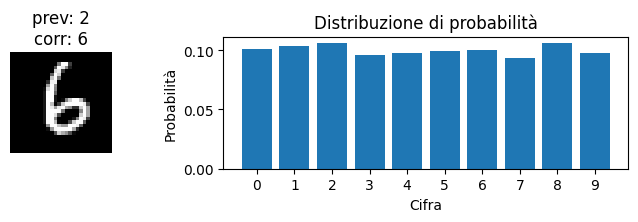

In [12]:
test_with_prob(test_data, network)

Addestriamo la rete in accordo agli iperparametri specificati in precedenza e, contestualmente, mettiamola alla prova.

In [13]:
start_time = time.time()
print("Epoca\tErrore\tAccuratezza")
for t in range(epochs):
    loss = train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network)
    print(f"{t+1}\t{loss:.3f}\t{100*correct/batch_size:.1f}%")
end_time = time.time()

print(f"Processo completato, in {end_time - start_time:.2f} secondi")

Epoca	Errore	Accuratezza
1	2.278	26.0%
2	2.249	32.0%
3	2.222	56.0%
4	2.198	56.0%
5	2.124	66.0%
6	2.060	68.0%
7	1.947	76.0%
8	1.826	72.0%
9	1.627	76.0%
10	1.406	68.0%
11	1.413	76.0%
12	1.300	76.0%
13	1.105	80.0%
14	1.011	76.0%
15	0.821	76.0%
16	0.574	84.0%
17	0.759	84.0%
18	0.649	84.0%
19	0.488	80.0%
20	0.666	88.0%
Processo completato, in 32.81 secondi


Valutiamo di nuovo quantitativamente l'accuratezza delle previsioni.

In [14]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network)
print(f"Accuratezza: {100*correct/batch_size:.1f}%")

Accuratezza: 84.1%


Valutiamo qualitativamente l'accuratezza delle previsioni, confrontando la cifra prevista ("prev") e quella corretta ("corr") per 10 immagini a caso.

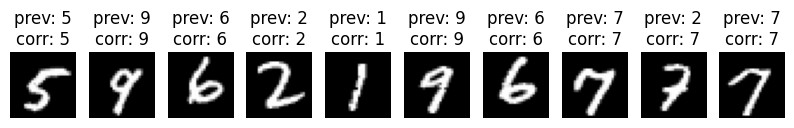

In [17]:
test_loop_with_trace(test_data, network)

Valutiamo il caso di una singola immagine, confrontando la cifra prevista ("prev") e quella corretta ("corr"), e visualizziamo la distribuzione di probabilità risultato dell'inferenza, da cui si sceglie la cifra prevista come quella più probabile.

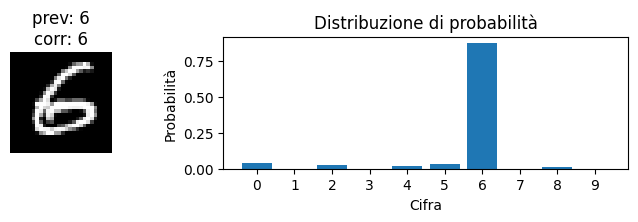

In [18]:
test_with_prob(test_data, network)

Ovviamente si potrebbe raffinare questo metodo di decisione, per esempio per non proporre alcuna previsione se la differenza fra le due probabilità maggiori non è abbastanza grande.